# QUORA: IDENTIFYING QUESTION PAIRS WITH THE SAME INTENT

### Importing the necessary libraries 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud # Importing wordcloud library for checking the most frequently occuring words
%matplotlib inline  

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.metrics import fbeta_score
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score


### Exploring the dataset

In [ ]:
# Loading the dataset
data = pd.read_csv("questions.csv" ,engine='python')

In [56]:
data.head(5)

id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   2     5     6  How can I increase the speed of my internet co...   
3   3     7     8  Why am I mentally very lonely? How can I solve...   
4   4     9    10  Which one dissolve in water quikly sugar, salt...   

                                           question2  is_duplicate  
0  What is the step by step guide to invest in sh...             0  
1  What would happen if the Indian government sto...             0  
2  How can Internet speed be increased by hacking...             0  
3  Find the remainder when [math]23^{24}[/math] i...             0  
4            Which fish would survive in salt water?             0

In [57]:
# Ignoring the warnings
import warnings
warnings.filterwarnings('ignore')

In [58]:
# Some Important Information about the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404351 entries, 0 to 404350
Data columns (total 6 columns):
id              404351 non-null int64
qid1            404351 non-null int64
qid2            404351 non-null int64
question1       404350 non-null object
question2       404349 non-null object
is_duplicate    404351 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [59]:
# Description of the dataset, in terms of count, mean , std dev etc.
data.describe()

id           qid1           qid2   is_duplicate
count  404351.000000  404351.000000  404351.000000  404351.000000
mean   202175.000000  391840.987691  390195.973765       0.369248
std    116726.223686  228430.857607  228803.645742       0.482602
min         0.000000       1.000000       2.000000       0.000000
25%    101087.500000  193381.000000  191012.000000       0.000000
50%    202175.000000  390630.000000  388364.000000       0.000000
75%    303262.500000  589514.000000  588071.000000       1.000000
max    404350.000000  789800.000000  789801.000000       1.000000

In [60]:
duplicate_questions = data['is_duplicate'].sum()     # Target Variable

print('Total number of questions in the dataset:  {}'.format(data.shape[0])) 
print('Total number of duplicate questions in the dataset: {}'.format(duplicate_questions)) 
print('Ratio of duplicate questions in the dataset: {:.2f}% '.format(100*duplicate_questions/data.shape[0]))
plt.figure(figsize=(10,5))
plt.title("Distribution of data (Duplicates/Non-Duplicates)")
data.groupby("is_duplicate")['id'].count().plot.bar()

Total number of questions in the dataset:  404351
Total number of duplicate questions in the dataset: 149306
Ratio of duplicate questions in the dataset: 36.92% 


### Data Preprocessing and Visualizing the dataset

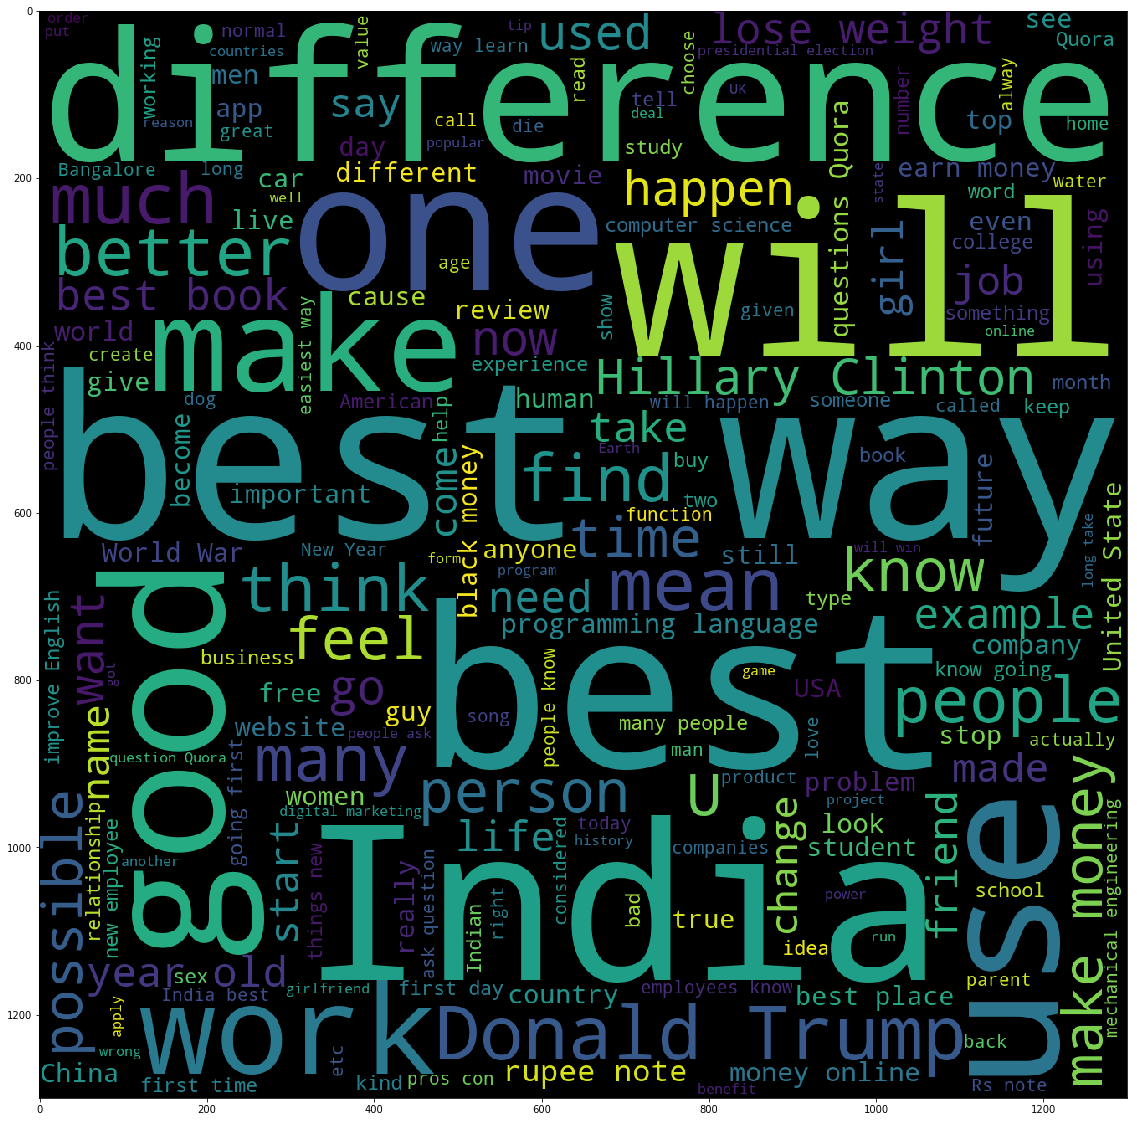

In [7]:

# Checking the most frequently occuring words
word_cloud_1 = WordCloud(width=800, height=800).generate(" ".join(data['question1'].astype(str)))
word_cloud_2 = WordCloud(width=1300, height=1300).generate(" ".join(data['question2'].astype(str)))

plt.figure(figsize=(20, 20))
plt.imshow(word_cloud_1)

plt.figure(figsize=(20, 20))
plt.imshow(word_cloud_2)

Observation: The above two plots clearly shows that there are some frequently occuring common words in the two questions (question1 and question2). For example: 'difference', ' Donald Trump' etc.

###### Note: Word Cloud is a data visualization technique used for representing text data in which the size of each word indicates its frequency or importance. Significant textual data points can be highlighted using a word cloud.

In [ ]:
"""
Function to calculate normalized word share between two questions

Equation: {(Common Length of two questions (Shortest Length among the two questions)) / 
                    ((Length of Question 1) + (Length of Question 2))}
"""

def word_share(x):
    word_1 = set(map(lambda word: word.lower().strip(), str(x['question1']).split(" ")))
    word_2 = set(map(lambda word: word.lower().strip(), str(x['question2']).split(" ")))
    return 1.0 * len(word_1 & word_2)/(len(word_1) + len(word_2))

In [ ]:
"""
Function to calculate TF-IDF word share between two questions

"""
def tfidf_word_share(x):    
    count_vectorizer = CountVectorizer()
    document = []
    document.append(str(x['question1']))
    document.append(str(x['question2']))
    freq_term_matrix = count_vectorizer.fit_transform(document)
    tfidf = TfidfTransformer(norm="l2")
    tfidf.fit(freq_term_matrix)
    tf_idf_matrix_1 = tfidf.transform(freq_term_matrix)
    arr = cosine_similarity(tf_idf_matrix_1[0:1], tf_idf_matrix_1)
    return arr[0][1]

In [ ]:
"""
Features Construction:
1. length
2. number of words
3. word share 
4. tf-idf word share

""" 
new_data = pd.DataFrame(dtype='float64')
new_data['q1_length'] = data['question1'].str.len()   # Length of the question 1
new_data['q2_length'] = data['question2'].str.len()   # Length of the question 2
new_data['q1_words_num'] = data['question1'].apply(lambda x: len(str(x).split(" "))) # Number of words in question 1
new_data['q2_words_num'] = data['question2'].apply(lambda y: len(str(y).split(" "))) # Number of words in question 2
new_data['word_share'] = data.apply(word_share, axis=1) # Calculating word share between the two questions
new_data['TFIDF_share'] = data.apply(tfidf_word_share, axis=1, raw=True) # Calculating the tf-tdf word share between the two questions

In [55]:
new_data.head()

q1_length  q2_length  q1_words_num  q2_words_num  word_share  TFIDF_share
0       66.0       57.0            14            12    0.434783     0.920307
1       51.0       88.0             8            13    0.200000     0.424251
2       73.0       59.0            14            10    0.166667     0.225765
3       50.0       65.0            11             9    0.000000     0.000000
4       76.0       39.0            13             7    0.100000     0.272060

In [54]:
# Check if there's NaN values in the data. If yes, replace them.
np.sum(np.isnan(new_data))
new_data.loc[:,['q2_length','q1_length','word_share','TFIDF_share']] = np.nan_to_num(new_data.loc[:,['q2_length','q1_length'   \
                                                                                                     ,'word_share','TFIDF_share']])
np.sum(np.isnan(new_data))

q1_length       0
q2_length       0
q1_words_num    0
q2_words_num    0
word_share      0
TFIDF_share     0
dtype: int64

In [ ]:
# Plotting the pairwise relationships in a dataset.
new_data_plot = new_data
#sns.pairplot(new_data_plot);

In [ ]:
"""
# Correlation between the features
new_data_plot['Target'] = data['is_duplicate']   # Length of the question 1

# calculate correlation
corr = new_data_plot.corr()

# plot correlation matrix
fig = plt.figure(figsize=(7, 5.5))
#mask = np.zeros_like(corr, dtype=np.bool) # create mask to cover the upper triangle
#mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, annot=True, vmax=0.5,linewidths=0.1)
fig.suptitle('Correlation Matrix', fontsize=14)
"""


"\nplt.figure(figsize=(20, 10))\nplt.hist(new_data['q1_length'], bins=400, range=[0, 400], color='green', normed=True, label='Q1')\nplt.hist(new_data['q2_length'], bins=400, range=[0, 400], color='yellow',alpha = 0.5, normed=True, label='Q2')\nplt.title('Normalised histogram of character count in questions', fontsize=15)\nplt.legend()\nplt.xlabel('Number of characters', fontsize=15)\nplt.ylabel('Probability', fontsize=15)\n"

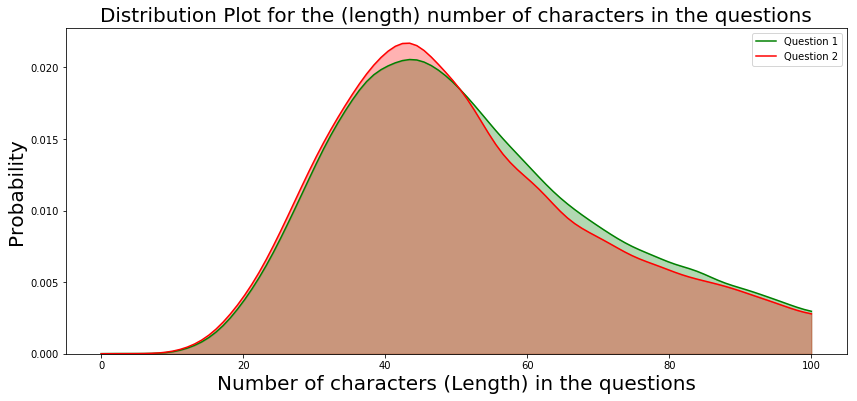

In [50]:
# Visualisation based on the feature : Length (Character Count)

plt.figure(figsize=(14, 6))
plt.title('Distribution Plot for the (length) number of characters in the questions', fontsize=20)
plt.ylabel('Probability', fontsize=20)
ax = sns.distplot(new_data['q1_length'], color='green', hist=False,fit_kws={"color":"green"}, kde_kws={"clip": [0,100]}, label = 'Question 1')
ax = sns.distplot(new_data['q2_length'], color='red', hist=False,fit_kws={"color":"red"},  kde_kws={"clip": [0,100]}, label = 'Question 2')
plt.legend()

# Get the two lines from the axes to generate shading
l1 = ax.lines[0]
l2 = ax.lines[1]

# Get the xy data from the lines so that we can shade
x1 = l1.get_xydata()[:,0]
y1 = l1.get_xydata()[:,1]
x2 = l2.get_xydata()[:,0]
y2 = l2.get_xydata()[:,1]
ax.fill_between(x1,y1, color="green", alpha=0.3)
ax.fill_between(x2,y2, color="red", alpha=0.3)
plt.xlabel('Number of characters (Length) in the questions', fontsize=20)

"""
plt.figure(figsize=(20, 10))
plt.hist(new_data['q1_length'], bins=400, range=[0, 400], color='green', normed=True, label='Q1')
plt.hist(new_data['q2_length'], bins=400, range=[0, 400], color='yellow',alpha = 0.5, normed=True, label='Q2')
plt.title('Normalised histogram of character count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of characters', fontsize=15)
plt.ylabel('Probability', fontsize=15)
"""


Observation: The above plot clearly shows that most of the questions are of length : 40-50

"\nplt.figure(figsize=(12, 8))\nplt.hist(new_data['q1_words_num'], bins=np.linspace(0, 70, 70), range=[0, 70], normed = True, color='blue', label='Q1')\nplt.hist(new_data['q2_words_num'], bins=np.linspace(0, 70, 70), range=[0, 70], normed = True, color='red',alpha = 0.5, label='Q2')\nplt.title('Normalized histogram of word count in questions', fontsize=15)\nplt.legend()\nplt.xlabel('Number of words', fontsize=15)\nplt.ylabel('Probability', fontsize=15)\n\n"

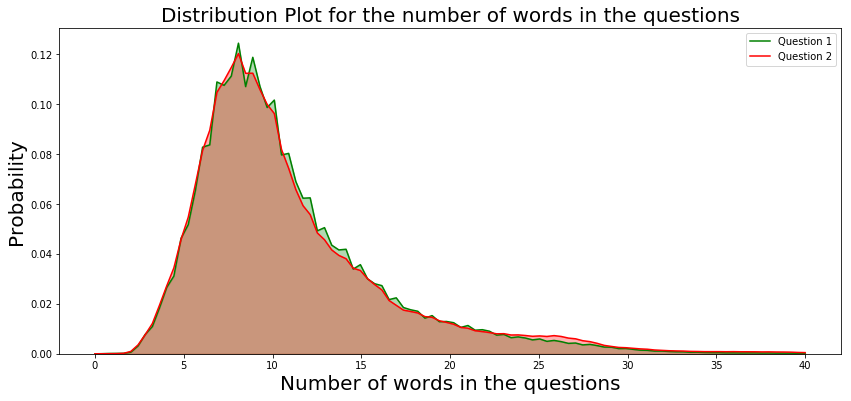

In [51]:
# Visualisation based on the feature : Number of words in the question

plt.figure(figsize=(14,6))
plt.title('Distribution Plot for the number of words in the questions', fontsize=20)
plt.ylabel('Probability', fontsize=20)
ax= sns.distplot(new_data['q1_words_num'], color='green', hist=False,fit_kws={"color":"blue"}, kde_kws={"clip": [0,40]}, label = 'Question 1')
ax = sns.distplot(new_data['q2_words_num'], color='red', hist=False,fit_kws={"color":"red"},  kde_kws={"clip": [0,40]}, label = 'Question 2')
plt.legend()

# Get the two lines from the axes to generate shading
l1 = ax.lines[0]
l2 = ax.lines[1]

# Get the xy data from the lines so that we can shade
x1 = l1.get_xydata()[:,0]
y1 = l1.get_xydata()[:,1]
x2 = l2.get_xydata()[:,0]
y2 = l2.get_xydata()[:,1]
ax.fill_between(x1,y1, color="green", alpha=0.3)
ax.fill_between(x2,y2, color="red", alpha=0.3)
plt.xlabel('Number of words in the questions', fontsize=20)


"""
plt.figure(figsize=(12, 8))
plt.hist(new_data['q1_words_num'], bins=np.linspace(0, 70, 70), range=[0, 70], normed = True, color='blue', label='Q1')
plt.hist(new_data['q2_words_num'], bins=np.linspace(0, 70, 70), range=[0, 70], normed = True, color='red',alpha = 0.5, label='Q2')
plt.title('Normalized histogram of word count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Probability', fontsize=15)

"""






Observation: The above plot clearly shows that most of the questions have 7-11 words.

Text(0.5,0,'word_share')

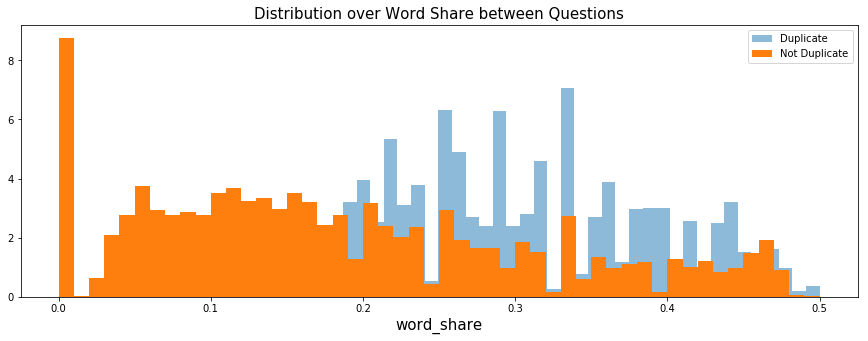

In [52]:
# Visualisation based on the feature : Word Share

plt.figure(figsize=(15, 5))
plot_word_share = new_data['word_share']
plt.hist(plot_word_share[data['is_duplicate'] == 1], bins=50, normed=True, alpha=0.5, label='Duplicate')
plt.hist(plot_word_share[data['is_duplicate'] == 0], bins=50, normed=True, label='Not Duplicate')
plt.legend()
plt.title('Distribution over Word Share between Questions', fontsize=15)
plt.xlabel('word_share', fontsize=15)

Text(0.5,0,'TFIDF_share')

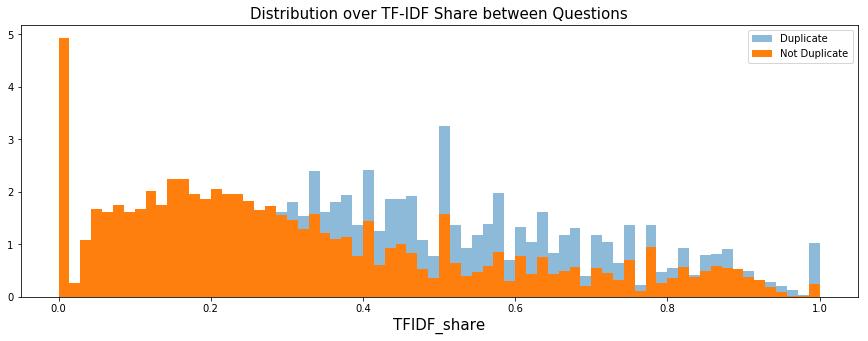

In [53]:
# Visualisation based on the feature : TF-IDF Word Share
plt.figure(figsize=(15, 5))
plot_tfidf_share = new_data['TFIDF_share']
plt.hist(plot_tfidf_share[data['is_duplicate'] == 1], bins=70, normed=True, alpha=0.5, label='Duplicate')
plt.hist(plot_tfidf_share[data['is_duplicate'] == 0], bins=70, normed=True, label='Not Duplicate')
plt.legend()
plt.title('Distribution over TF-IDF Share between Questions', fontsize=15)
plt.xlabel('TFIDF_share', fontsize=15)

Observation: The above two plots clearly shows that the ratio of both word share and tf-idf word share is higher for duplicate questions than for non-duplicate questions.

### Normalizing the dataset

In [25]:
# Normalized feature values
# Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
new_data_scaled = scaler.fit_transform(new_data)

### Splitting the dataset into training and testing sets

In [26]:
label = data['is_duplicate']   # Target Set
X_train, X_test, y_train, y_test = train_test_split(new_data_scaled, label, test_size=0.2, random_state=10)
#X_train_scaled, X_valid_scaled, y_train, y_valid = train_test_split(new_data_scaled, label, test_size=0.2, random_state=10)

### Performance Metric : Calculating the accuracy for Naive Classifier ( Benchmark )

In [27]:
# naive classifier -- > Assuming that all the questions are duplicate

duplicates = data[data['is_duplicate'] == 1]
accuracy = duplicates.shape[0]/new_data_scaled.shape[0]
precision = duplicates.shape[0]/new_data_scaled.shape[0]
recall = duplicates.shape[0]/duplicates.shape[0]
beta = 2
fscore = (1 + beta**beta) * (precision * recall) /(beta**beta * precision + recall)
print("Accuracy is %.2f " %(accuracy * 100),"%")

"""
#print("F2 score is {:.4f}".format(fscore))
"""


Accuracy is 36.92  %


'\n#print("F2 score is {:.4f}".format(fscore))\n'

In [28]:
model_results = []
del model_results[:]

### Implemention 

##### Random Forest

In [29]:
# Model 1:  Random forest
rf_classifier = RandomForestClassifier(max_depth=5, random_state=29)
rf_classifier.fit(X_train,y_train)
prediction = rf_classifier.predict_proba(X_test)
random_forest_score = rf_classifier.score(X_test, y_test)
print ("Random Forest model accuracy: %.2f " %(random_forest_score*100),"%")
"""
# F2-Score Calculation
predict = rf_classifier.predict(X_test)
random_forest_fscore = fbeta_score(y_test, predict, average='macro', beta=2)
print ("Random Forest has fscore: ", random_forest_fscore)

"""
kfold = KFold(n_splits=20, random_state=7)
accuracy = cross_val_score(rf_classifier, new_data_scaled, label, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (accuracy.mean()*100, accuracy.std()*100))
model_results.append(accuracy)
#model_results.append(random_forest_score)

Random Forest model accuracy: 70.00  %
Accuracy: 69.93% (0.37%)


#### Decision Tree

In [30]:
# Model 2: Decision tree 
dt_classifier = DecisionTreeClassifier(max_depth = 200, random_state=29)
dt_classifier.fit(X_train, y_train)
prediction = dt_classifier.predict(X_train)
decision_tree_score = dt_classifier.score(X_test, y_test)
print ("Decision tree model accuracy: %.2f" %(decision_tree_score*100),"%")
"""
# F2-Score Calculation
predict = dt_classifier.predict(X_test)
decision_tree_fscore = fbeta_score(y_test, predict, average='macro', beta=2)
print ("Decision tree model has fscore: ", decision_tree_fscore)

"""
accuracy = cross_val_score(dt_classifier, new_data_scaled, label, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (accuracy.mean()*100, accuracy.std()*100))
model_results.append(accuracy)
#model_results.append(decision_tree_score)

Decision tree model accuracy: 67.72 %
Accuracy: 67.75% (0.32%)


#### Logistic Regression

In [31]:
# Model 3: Logistic Regression
lr_classifier = LogisticRegression()
lr_classifier.fit (X_train,y_train)
prediction = lr_classifier.predict(X_train)
logistic_reg_score = lr_classifier.score(X_test, y_test)
print ("Logistic Regression model accuracy: %.2f" %(logistic_reg_score*100),"%")
"""
# F2-Score Calculation
predict = lr_classifier.predict(X_test)
logistic_reg_fscore = fbeta_score(y_test, predict, average='macro', beta=2)
print ("Logistic Regression model has fscore: ", logistic_reg_fscore)

"""
#model_results.append(logistic_reg_score)

Logistic Regression model accuracy: 66.36 %


'\n# F2-Score Calculation\npredict = lr_classifier.predict(X_test)\nlogistic_reg_fscore = fbeta_score(y_test, predict, average=\'macro\', beta=2)\nprint ("Logistic Regression model has fscore: ", logistic_reg_fscore)\n\n'

#### Support Vector Machine

In [32]:
# Model 4: SVM  --> Without Exhaustive Grid Search
#svm_classifier = SVC(C=1.5, cache_size=5000, class_weight=None, coef0=0.0,
#    decision_function_shape='ovr', degree=2, gamma='auto', kernel='rbf', probability=True, random_state=None, shrinking=True,
#    tol=0.01, verbose=True,max_iter=500, random_state = 29)
svm_classifier = SVC(probability=True,verbose=True,max_iter=500, random_state = 29)

svm_classifier.fit (X_train,y_train)
prediction = svm_classifier.predict(X_train)
svm_score = svm_classifier.score(X_test, y_test)
print ("SVM model accuracy (without exhaustive grid search): %.2f" %(svm_score* 100), "%")


[LibSVM]SVM model accuracy (without exhaustive grid search): 67.85 %


In [33]:
# Model 4: SVM  --> With Exhaustive Grid Search
svm_classifier = SVC(probability=True,verbose=True,max_iter=700, random_state = 29)
cv_grid = {
    'C': [0.5, 1.0, 1.5, 2.0],
    'kernel': ['poly', 'rbf', 'sigmoid']
}
classifier = GridSearchCV(svm_classifier, cv_grid, scoring='neg_log_loss', verbose = False)

classifier.fit(X_train, y_train)
print( "Best Parameters are :   " , classifier.best_params_ )
score_svm = classifier.best_estimator_.score(X_test, y_test)
print ("SVM model accuracy (with exhaustive grid search): %.2f" %(score_svm*100),"%")

accuracy = cross_val_score(svm_classifier, new_data_scaled, label, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (accuracy.mean()*100, accuracy.std()*100))
model_results.append(accuracy)
#model_results.append(svm_score)

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Best Parameters are :    {'kernel': 'sigmoid', 'C': 0.5}
SVM model accuracy (with exhaustive grid search): 55.80 %
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Accuracy: 56.82% (6.39%)


#### K-Nearest Neighbours

In [34]:
# Model 5: K Nearest Neighbors --> Using grid search for best parameter

knn_classifier = KNeighborsClassifier()
knn_grid = {
    'n_neighbors': list(range(2, 10, 15)),
    'weights': ['uniform', 'distance']
}
classifier = GridSearchCV(knn_classifier, knn_grid, scoring='neg_log_loss', verbose = True)
classifier.fit(X_train, y_train)
print ("Best Parameters are : ", classifier.best_params_)
knn_score = classifier.best_estimator_.score(X_test, y_test)
print ("K Nearest Neighbor model accuracy (with exhaustive grid search) : %.2f" %(knn_score*100), "%")

accuracy = cross_val_score(knn_classifier, new_data_scaled, label, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (accuracy.mean()*100, accuracy.std()*100))
model_results.append(accuracy)

#model_results.append(knn_score)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  1.2min finished


Best Parameters are :  {'n_neighbors': 2, 'weights': 'uniform'}
K Nearest Neighbor model accuracy (with exhaustive grid search) : 67.98 %
Accuracy: 70.05% (0.26%)


#### XGBoost

In [35]:
# Model 6: XGBoost -> With Default parameters

xgb_classifier = XGBClassifier()
xgb_classifier.fit(X_train, y_train)
y_pred = xgb_classifier.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f"  %(accuracy * 100.0),"%")


Accuracy: 70.86 %


In [36]:
# Model 6: XGBoost -> With Default parameters and K-Fold Cross Validation

xgb_classifier = XGBClassifier()
kfold = KFold(n_splits=20, random_state=7)
accuracy = cross_val_score(xgb_classifier, new_data_scaled, label, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (accuracy.mean()*100, accuracy.std()*100))
model_results.append(accuracy)

Accuracy: 70.86% (0.29%)


In [37]:
# Model 6: XGBoost -> With Default parameters, K-Fold Cross Validation and parameters tunning

grid_cv_params = {'max_depth': [3,5,7], 'min_child_weight': [1,3,5]}
xgb_params = {'learning_rate': 0.1, 'n_estimators': 1000, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic'}
model = GridSearchCV(xgb.XGBClassifier(**xgb_params), grid_cv_params, scoring = 'accuracy', cv = 5, n_jobs = -1)
model.fit(X_train, y_train)
print("Checking Parameters performing the best:")
print(model.grid_scores_)

Checking Parameters performing the best:
[mean: 0.72070, std: 0.00129, params: {'min_child_weight': 1, 'max_depth': 3}, mean: 0.72075, std: 0.00122, params: {'min_child_weight': 3, 'max_depth': 3}, mean: 0.72058, std: 0.00126, params: {'min_child_weight': 5, 'max_depth': 3}, mean: 0.72632, std: 0.00117, params: {'min_child_weight': 1, 'max_depth': 5}, mean: 0.72635, std: 0.00090, params: {'min_child_weight': 3, 'max_depth': 5}, mean: 0.72599, std: 0.00085, params: {'min_child_weight': 5, 'max_depth': 5}, mean: 0.72678, std: 0.00109, params: {'min_child_weight': 1, 'max_depth': 7}, mean: 0.72664, std: 0.00138, params: {'min_child_weight': 3, 'max_depth': 7}, mean: 0.72615, std: 0.00148, params: {'min_child_weight': 5, 'max_depth': 7}]


##### Using XGBoost Classifier, the accuracy obtained is 72.4%, which is better than the accuarcy obtained with each of the models implemented above.

##### Currenly, Quora uses Random Forest Model for solving this problem, So, XGBoost Classifier's accuracy is above the accuarcy of both the benchmark models (Naive Classifier and Random Forest)Hence, the best model selected is XGBoost.

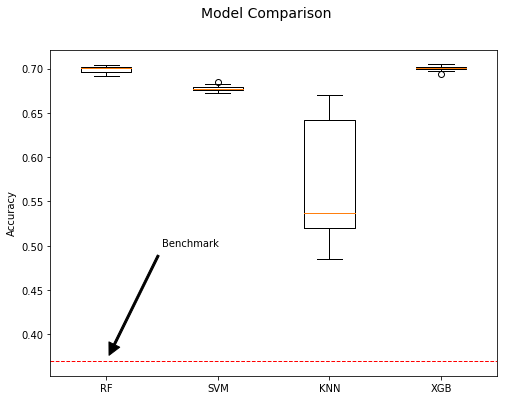

In [69]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
plt.boxplot(model_results[:-1])

ax.axhline(y=0.37, linewidth=1, color='r', linestyle='dashed')
ax.annotate('Benchmark', xy=(1, 0.37), xytext=(1.5, 0.5),
            arrowprops=dict(facecolor='black', shrink=0.05, width=2),
            )
names = ['RF','SVM','KNN','XGB']
ax.set_xticklabels(names)
ax.set_ylabel('Accuracy')
fig.suptitle('Model Comparison', fontsize=14)
plt.savefig("img1.jpg")

In [70]:
# Model 6: XGBoost ---> More Parameter Tuning

params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.01
params['gamma'] = 25
params['colsample_bytree'] = 0.5
params['min_child_weight'] = 10
params['max_depth'] = 6
params['subsample'] = 0.5

xgb_train = xgb.DMatrix(X_train, label=y_train)
xgb_test = xgb.DMatrix(X_test, label=y_test)
watchlist = [(xgb_train, 'train'), (xgb_test, 'test')]

#print("Len:   ", (xgb_train))
bst = xgb.train(params, xgb_train, 500,watchlist, early_stopping_rounds=100, verbose_eval=10)
p_test = bst.predict(xgb_test)
score_xgb = xgb.cv(params, xgb_train, num_boost_round=10, nfold=3, stratified=False, 
                   folds=None, metrics=(), obj=None, feval=None, maximize=False,
                   early_stopping_rounds=100, fpreproc=None, as_pandas=True, verbose_eval=10, show_stdv=True, seed=0, callbacks=None, shuffle=True)

#score_xgb = accuracy_score(y_test, p_test)
print ("XGBoost: %.3f",score_xgb)

[0]	train-logloss:0.690714	test-logloss:0.690701
Multiple eval metrics have been passed: 'test-logloss' will be used for early stopping.

Will train until test-logloss hasn't improved in 100 rounds.
[10]	train-logloss:0.668193	test-logloss:0.66812
[20]	train-logloss:0.649152	test-logloss:0.648991
[30]	train-logloss:0.63429	test-logloss:0.634097
[40]	train-logloss:0.621534	test-logloss:0.62129
[50]	train-logloss:0.608305	test-logloss:0.608022
[60]	train-logloss:0.599906	test-logloss:0.599601
[70]	train-logloss:0.592387	test-logloss:0.592068
[80]	train-logloss:0.583199	test-logloss:0.582867
[90]	train-logloss:0.576986	test-logloss:0.576644
[100]	train-logloss:0.570586	test-logloss:0.570229
[110]	train-logloss:0.564425	test-logloss:0.564071
[120]	train-logloss:0.559011	test-logloss:0.558652
[130]	train-logloss:0.5545	test-logloss:0.554119
[140]	train-logloss:0.549542	test-logloss:0.549155
[150]	train-logloss:0.545258	test-logloss:0.544862
[160]	train-logloss:0.541721	test-logloss:0.54131


LogLoss for XGBoost Classifier has also reduced a lot.

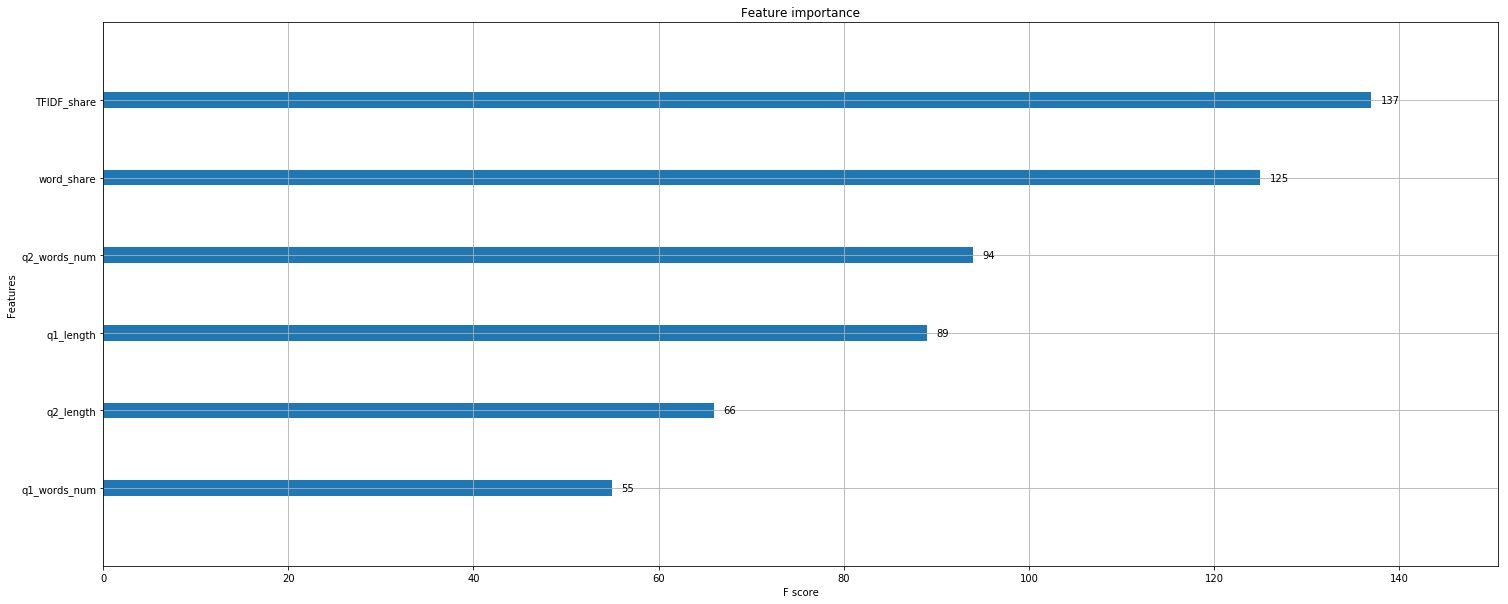

In [68]:
#Visualize the prediction
from matplotlib.pylab import rcParams
from xgboost import plot_tree
rcParams['figure.figsize'] = (25,10)
bst.feature_names = ['q1_length','q2_length','q1_words_num','q2_words_num','word_share','TFIDF_share']
#print(bst.feature_names)
xgb.plot_importance(bst)
plt.savefig("img2.jpg")

The above plot shows the feature importance of each of the features used to train the model.

#### Model Validation: Generaing the accuracy scores for models trained with different sample size


In [ ]:
# different training set size
sample_1 = round(0.01 * X_train.shape[0])
sample_5 = round(0.05 * X_train.shape[0])
sample_10 = round(0.1 * X_train.shape[0])
sample_20 = round(0.2 * X_train.shape[0])
sample_50 = round(0.5 * X_train.shape[0])

train_results = []
test_results = []
for i, samples in enumerate([sample_1, sample_5, sample_10, sample_20, sample_50]):
    model.fit(X_train[:samples], y_train[:samples])
    pred_train = model.predict(X_train[:samples])
    pred_test = model.predict(X_test)
    train_results.append(accuracy_score(y_train[:samples], pred_train))
    test_results.append(accuracy_score(y_test, pred_test))
    #print(train_results, "   ", test_results)

Training Set Scores :   [0.8686244204018547, 0.7759366885124274, 0.74907258563126, 0.7373407938666996, 0.7523370842092246]
    
Testing Set Scores :  [0.6857340703095053, 0.7080659321635692, 0.7152625786746795, 0.7183662870497459, 0.7249570303322576]


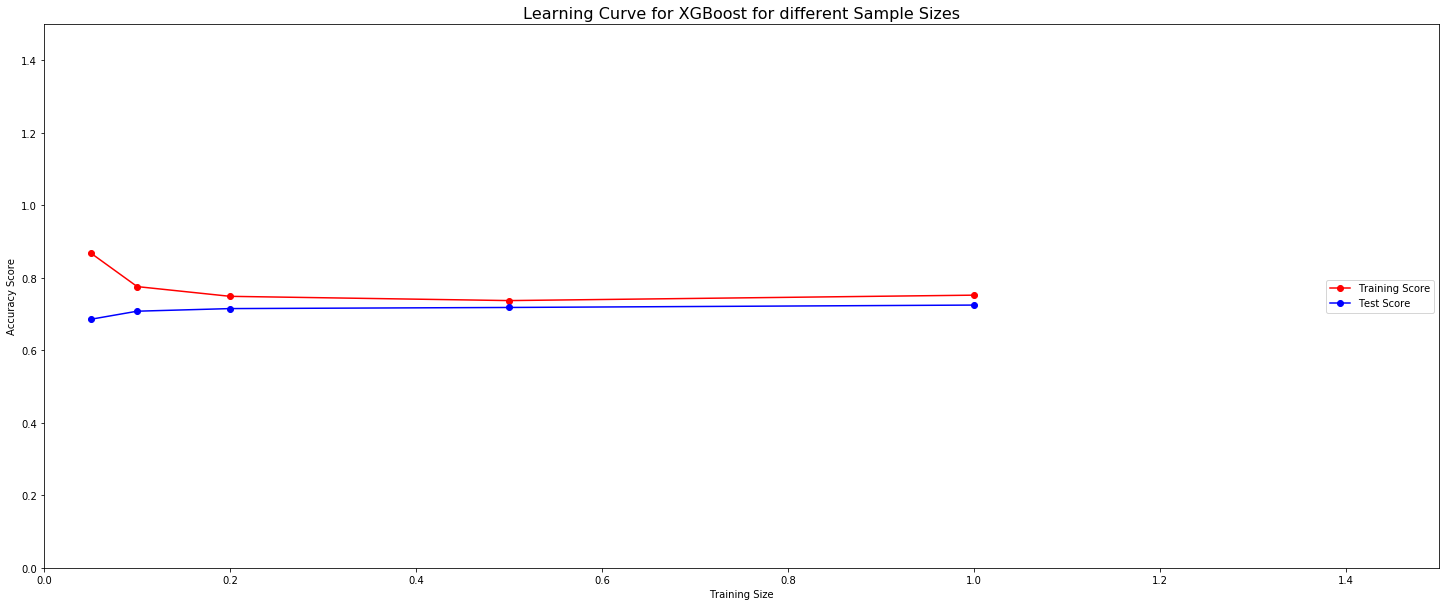

In [86]:
# plotting the learning curves for the model
print("Training Set Scores :  " , train_results)
print("    ")
print("Testing Set Scores : " , test_results)

plt.plot(index, train_results, 'o-', color='red', label='Training Score')
plt.plot(index, test_results, 'o-', color='blue', label='Test Score')
plt.xlim([0,1.5])
plt.ylim([0, 1.5])
plt.xlabel('Training Size')
plt.ylabel('Accuracy Score')
plt.legend(bbox_to_anchor=(1, 0.5), loc='right')
plt.title('Learning Curve for XGBoost for different Sample Sizes', fontsize=16, y=1)
plt.savefig("img5.jpg")